In [1]:
import torch
import torch.nn as nn
import re
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

In [5]:
class HTMEncoder(nn.Module):
    def __init__(self, vocab, cells_per_column=16):
        super().__init__()
        self.vocab = vocab
        self.columns = len(vocab)
        self.cells_per_column = cells_per_column
        self.total_cells = self.columns * self.cells_per_column
        self.col_to_word = {col_idx: word for word, col_idx in vocab.items()}
        self.word_to_cells = {
            word: self._allocate_cells(idx) for word, idx in vocab.items()
        }

    def _allocate_cells(self, column_idx):
        start = column_idx * self.cells_per_column
        return [start]

    def encode(self, word):
        vec = torch.zeros(self.total_cells)
        for i in self.word_to_cells.get(word, []):
            vec[i] = 1.0
        return vec

    def decode(self, vec):
        active_cells = torch.nonzero(vec).flatten().tolist()
        col_indices = {i // self.cells_per_column for i in active_cells}
        return [self.col_to_word.get(col, "<unknown>") for col in col_indices]


class DeterministicHTPC:
    def __init__(self, word_list, cells_per_column=16):
        self.vocab = {word: i for i, word in enumerate(sorted(set(word_list)))}
        self.encoder = HTMEncoder(self.vocab, cells_per_column=cells_per_column)
        self.transition_counts = defaultdict(int)
        self.last_encoded = None
        self.last_schema = None

    def train_pair(self, word1, word2, schema_id=None):
        pre = self.encoder.encode(word1)
        post = self.encoder.encode(word2)
        for i in torch.nonzero(pre).flatten():
            for j in torch.nonzero(post).flatten():
                self.transition_counts[(i.item(), j.item(), schema_id)] += 1

    def input_word(self, word, schema_id=None):
        self.last_encoded = self.encoder.encode(word)
        self.last_schema = schema_id

    def predict_next(self, top_k=3, return_probs=False):
        if self.last_encoded is None:
            return ["<no_input>"]
        pre_indices = torch.nonzero(self.last_encoded).flatten().tolist()
        post_counts = defaultdict(float)
        for pre in pre_indices:
            for (p, q, sid), count in self.transition_counts.items():
                if p == pre and sid == self.last_schema:
                    post_counts[q] += count
        if not post_counts:
            return ["<unknown>"]
        total = sum(post_counts.values())
        sorted_posts = sorted(post_counts.items(), key=lambda x: -x[1])
        top_post_indices = sorted_posts[:top_k]
        result = []
        for post_idx, count in top_post_indices:
            word = self.encoder.decode(torch.eye(self.encoder.total_cells)[post_idx])[0]
            prob = count / total
            result.append((word, round(prob, 3)) if return_probs else word)
        return result

    def simulate_forward(self, start_word, steps=3, schema_id=None):
        self.input_word(start_word, schema_id=schema_id)
        sequence = [start_word]
        for _ in range(steps):
            preds = self.predict_next(top_k=1)
            next_word = preds[0] if isinstance(preds[0], str) else preds[0][0]
            if next_word == "<unknown>":
                break
            sequence.append(next_word)
            self.input_word(next_word, schema_id=schema_id)
        return sequence

    def export_transition_graph(self, schema_id=0):
        G = nx.DiGraph()
        for (pre, post, sid), count in self.transition_counts.items():
            if sid != schema_id:
                continue
            w1 = self.encoder.decode(torch.eye(self.encoder.total_cells)[pre])[0]
            w2 = self.encoder.decode(torch.eye(self.encoder.total_cells)[post])[0]
            G.add_edge(w1, w2, weight=count)
        pos = nx.spring_layout(G, seed=42)
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        nx.draw(G, pos, with_labels=True, node_color='lightblue',
                edge_color='gray', width=edge_weights, font_size=10)
        nx.draw_networkx_edge_labels(G, pos,
                                     edge_labels={(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)},
                                     font_color='black')
        plt.title(f"Transition Graph (Schema {schema_id})")
        plt.show()

In [6]:
#with open("corpus.txt", "r") as f:
#    corpus = [line.strip() for line in f if line.strip()]

corpus = [
    "the cat sat on the mat",
    "the dog ran across the yard",
    "a cat jumped on the table"
    "a cat hide below the table",
    "the dog barks loud"
]

def extract_sequences(lines):
    all_words = set()
    schema_data = []
    for sid, line in enumerate(lines):
        tokens = re.findall(r'\b\w+\b', line.lower())
        all_words.update(tokens)
        pairs = [(tokens[i], tokens[i+1]) for i in range(len(tokens) - 1)]
        schema_data.append((sid, pairs))
    return sorted(all_words), schema_data

vocab, schema_sequences = extract_sequences(corpus)

# Init model
model = DeterministicHTPC(word_list=vocab, cells_per_column=16)

# Train
for schema_id, pairs in schema_sequences:
    for w1, w2 in pairs:
        model.train_pair(w1, w2, schema_id=schema_id)


In [7]:
model.input_word("cat", schema_id=0)
print("Predictions after 'cat':", model.predict_next(return_probs=True))

model.input_word("dog", schema_id=1)
print("Predictions after 'dog':", model.predict_next(return_probs=True))

model.input_word("cat", schema_id=2)
print("Forward simulation (schema 2):", model.simulate_forward("cat", steps=5, schema_id=2))


Predictions after 'cat': [('sat', 1.0)]
Predictions after 'dog': [('ran', 1.0)]
Forward simulation (schema 2): ['cat', 'jumped', 'on', 'the', 'tablea', 'cat']


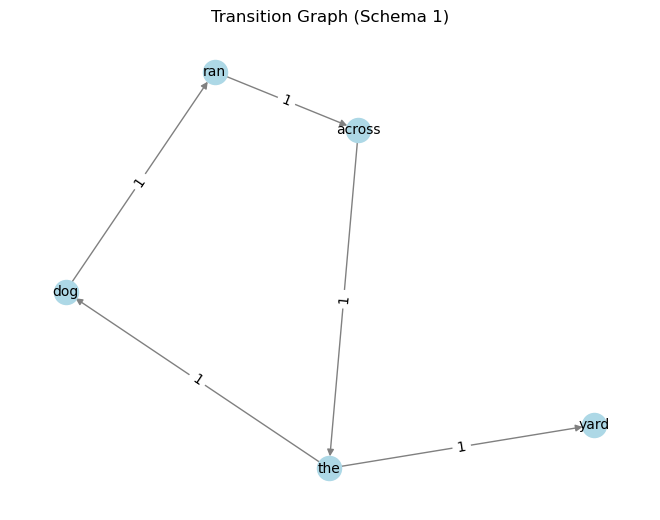

In [9]:
model.export_transition_graph(schema_id=1)
